In [1]:
import tensorflow as tf

import numpy as np
import IPython.display as display

In [30]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [3]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [4]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [5]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [7]:
print(feature0)
print(feature1)
print(feature2)
print(feature3)

[ True  True  True ... False  True  True]
[0 4 3 ... 4 4 3]
[b'cat' b'goat' b'horse' ... b'goat' b'goat' b'horse']
[-0.26032188  0.41010309 -0.57741496 ...  0.55078283  0.17789641
 -0.92279969]


In [36]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(int(feature0)),
      'feature1': _int64_feature(int(feature1)),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(float(feature3)),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [9]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

In [10]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876
      }
    }
  }
}

In [12]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int32>

In [13]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int32, tf.string, tf.float64)>

In [14]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'cat', shape=(), dtype=string)
tf.Tensor(-0.2603218771010913, shape=(), dtype=float64)


In [28]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar

In [37]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xe9H\x85\xbe'>

In [38]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [39]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [40]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [41]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [44]:
for f0 in serialized_features_dataset.take(1):
  print(f0)

tf.Tensor(b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xe9H\x85\xbe', shape=(), dtype=string)


In [45]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

from src.datasources.unityeyes import UnityEyes

In [2]:
unityeyes_path = 'E:/Datasets/UnityEyes_Windows/imgs'
u = UnityEyes(unityeyes_path=unityeyes_path)

In [98]:
entry = next(u.entry_generator())

In [99]:
print(entry)

{'radius': 63.11451, 'gaze': array([ 0.29599702, -0.04172527], dtype=float32), 'eye': array([[[-0.2862745 ],
        [-0.2862745 ],
        [-0.2862745 ],
        ...,
        [ 0.41960788],
        [ 0.41960788],
        [ 0.4431373 ]],

       [[-0.2862745 ],
        [-0.2862745 ],
        [-0.2862745 ],
        ...,
        [ 0.41960788],
        [ 0.4431373 ],
        [ 0.4431373 ]],

       [[-0.2862745 ],
        [-0.2862745 ],
        [-0.2862745 ],
        ...,
        [ 0.41960788],
        [ 0.41960788],
        [ 0.41960788]],

       ...,

       [[ 0.8039217 ],
        [ 0.8039217 ],
        [ 0.8039217 ],
        ...,
        [ 0.6784315 ],
        [ 0.6784315 ],
        [ 0.7019609 ]],

       [[ 0.8039217 ],
        [ 0.8039217 ],
        [ 0.81176484],
        ...,
        [ 0.6941178 ],
        [ 0.6941178 ],
        [ 0.7176472 ]],

       [[ 0.8039217 ],
        [ 0.8039217 ],
        [ 0.81176484],
        ...,
        [ 0.7176472 ],
        [ 0.7176472 ],
        

In [3]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
# Create a dictionary with features that may be relevant.
def image_example(entry):
    feature = {
      'radius': _float_feature(entry['radius']),
      'gaze': _bytes_feature(tf.io.serialize_tensor(entry['gaze'])),
      'landmarks': _bytes_feature(tf.io.serialize_tensor(entry['landmarks'])),
      'eye': _bytes_feature(tf.io.serialize_tensor(entry['eye'])),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [113]:
img_exp = image_example(entry)
img_exp

features {
  feature {
    key: "eye"
    value {
      bytes_list {
        value: "\010\001\022\016\022\003\010\220\001\022\003\010\360\001\022\002\010\001\"\200\270\010\222\222\222\276\222\222\222\276\222\222\222\276\222\222\222\276\222\222\222\276\222\222\222\276\242\242\242\276\266\266\266\276\266\266\266\276\266\266\266\276\266\266\266\276\266\266\266\276\266\266\266\276\266\266\266\276\242\242\242\276\242\242\242\276\242\242\242\276\242\242\242\276\242\242\242\276\242\242\242\276\266\266\266\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\266\266\266\276\266\266\266\276\266\266\266\276\266\266\266\276\242\242\242\276\266\266\266\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\322\322\322\276\266\266\266\276\242\242\242\276\242\242\242\276\222\222\222\

In [114]:
img_exp.SerializeToString()

b'\n\x95\xba\x08\n\x12\n\x06radius\x12\x08\x12\x06\n\x04Bu|B\n\x1e\n\x04gaze\x12\x16\n\x14\n\x12\x08\x01\x12\x04\x12\x02\x08\x02"\x08\xec\x8c\x97>\x1e\xe8*\xbd\n\xb3\x01\n\tlandmarks\x12\xa5\x01\n\xa2\x01\n\x9f\x01\x08\x01\x12\x08\x12\x02\x08\x12\x12\x02\x08\x02"\x90\x01\xd2\xc7HBz\x8a\x9eB\x0eZ_B\xc6\xe1UB\x1b\x96\xccB\xfe\xea\x17B\x94\x08!C\xac0\x82B\xe7\xb6<CYV\xaeB\xb6\xe4 C\xcb\x18\xd0B\xc4\xb6\xc7B\x06\xb5\xdfB\xdentB\x1e\x93\xc5Bkd\xbcB\xdb$MBX\xb4\xcfB\x1f\xdd\xdcAXA\x00C\xb7\xd7\x8cA4\x1c\x19C\x9e\x19\xd9Az\xdb#C\x86{JB\x843\x1aC\xe9\x98\x94BX\xcc\x01CC\x9a\xa8B\xf7\xe2\xd1B\xc9\x89\x95Bg\xb7\x00C\xc0\xeeTB{e\xfcBYI\x8fB\n\xa7\xb8\x08\n\x03eye\x12\x9e\xb8\x08\n\x9a\xb8\x08\n\x96\xb8\x08\x08\x01\x12\x0e\x12\x03\x08\x90\x01\x12\x03\x08\xf0\x01\x12\x02\x08\x01"\x80\xb8\x08\x92\x92\x92\xbe\x92\x92\x92\xbe\x92\x92\x92\xbe\x92\x92\x92\xbe\x92\x92\x92\xbe\x92\x92\x92\xbe\xa2\xa2\xa2\xbe\xb6\xb6\xb6\xbe\xb6\xb6\xb6\xbe\xb6\xb6\xb6\xbe\xb6\xb6\xb6\xbe\xb6\xb6\xb6\xbe\xb6\xb6\xb6\xbe\xb

In [8]:
# Write the raw image files to `UnityEyes.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
for x in range(10):
    record_file = './UnityEyes_100000_samples_36x60/UnityEyes_{}.tfrecords'.format(x)
    with tf.io.TFRecordWriter(record_file) as writer:
        i = 1
        while i <= 10000:
            entry = next(u.entry_generator())
            if entry == None:
                continue
            else:
                tf_example = image_example(entry)
                writer.write(tf_example.SerializeToString())
                i += 1

In [5]:
record_files = []
for x in range(50):
    record_file = './UnityEyes_100000_samples_144x240/UnityEyes_{}.tfrecords'.format(x)
    record_files.append(record_file)
record_files

['./UnityEyes_100000_samples_144x240/UnityEyes_0.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_1.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_2.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_3.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_4.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_5.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_6.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_7.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_8.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_9.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_10.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_11.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_12.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_13.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_14.tfrecords',
 './UnityEyes_100000_samples_144x240/UnityEyes_15.tfrecords',
 './UnityEyes_1000

In [2]:
dataset = tf.data.Dataset.list_files('./UnityEyes_100000_samples_36x60/train/*.tfrecords')
raw_image_dataset = tf.data.TFRecordDataset(dataset)

In [3]:
# Create a dictionary describing the features.
image_feature_description = {
    'radius': tf.io.FixedLenFeature([], tf.float32),
    'gaze': tf.io.FixedLenFeature([], tf.string),
    'landmarks': tf.io.FixedLenFeature([], tf.string),
    'eye': tf.io.FixedLenFeature([], tf.string),
}
def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [4]:
def parse_array_element(features):
    features['gaze'] = tf.io.parse_tensor(features['gaze'], tf.float32)
    features['landmarks'] = tf.io.parse_tensor(features['landmarks'], tf.float32)
    features['eye'] = tf.io.parse_tensor(features['eye'], tf.float32)
    return features

In [6]:
parsed_image_dataset = raw_image_dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
parsed_image_dataset

<ParallelMapDataset shapes: {eye: (), gaze: (), landmarks: (), radius: ()}, types: {eye: tf.string, gaze: tf.string, landmarks: tf.string, radius: tf.float32}>

In [211]:
i = 0
for image_features in parsed_image_dataset:
    i += 1
print(i)

100000


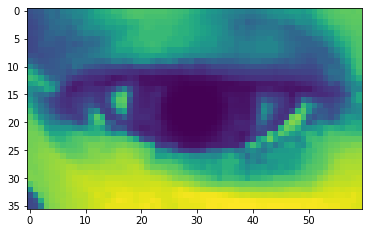

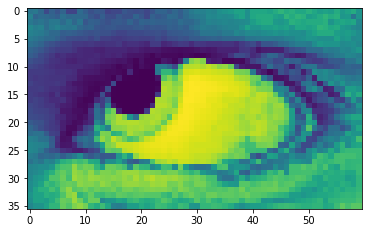

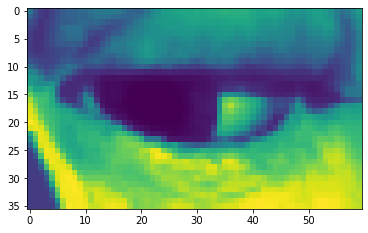

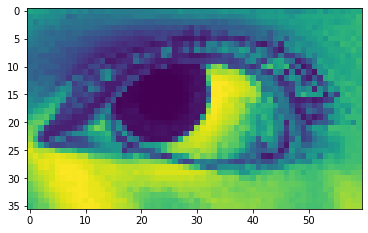

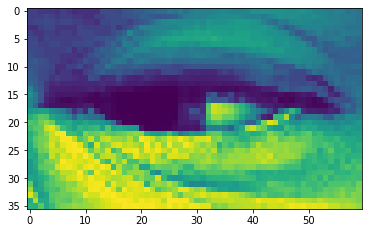

In [7]:
for image_features in parsed_image_dataset.take(5):
    img = tf.io.parse_tensor(image_features['eye'], tf.float32)
    plt.figure()
    plt.imshow(img)

In [7]:
parsed_image_dataset = parsed_image_dataset.map(parse_array_element, num_parallel_calls=tf.data.AUTOTUNE)
parsed_image_dataset

<ParallelMapDataset shapes: {eye: <unknown>, gaze: <unknown>, landmarks: <unknown>, radius: ()}, types: {eye: tf.float32, gaze: tf.float32, landmarks: tf.float32, radius: tf.float32}>

In [8]:
parsed_image_dataset = parsed_image_dataset.batch(32)
parsed_image_dataset = parsed_image_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
for one_batch in parsed_image_dataset.take(1):
    r = one_batch['landmarks'].shape
    print(r)

(32, 18, 2)
